In [83]:
# Mount Google Drive to access files stored in your Drive within this Colab session
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [84]:
# Install specific version of NumPy and the Gensim library for numerical operations and word embeddings
!pip install numpy==1.25.0
!pip install gensim

In [85]:
# Import NumPy and print its version to confirm the installed version
import numpy as np
print(np.__version__)

1.25.0


In [86]:
# Import essential libraries for data processing, visualization, NLP, and deep learning; download required NLTK resources
import pandas as pd
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

#### Loading the dataset

In [87]:
# Load the hate speech dataset from Google Drive into a pandas DataFrame
dataset_path = "/content/drive/MyDrive/6CS012 AI & ML/text classification/Racist Sexist or Not Dataset/7. Racist Sexist or Not Dataset/train_racisit.csv"
df = pd.read_csv(dataset_path)

In [88]:
df.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [89]:
# Check if there are any missing (null) values in each column of the DataFrame
df.isnull().any()

,0
id,False
label,False
tweet,False


In [90]:
# Define a text cleaning function to preprocess tweets by removing noise (URLs, emojis, mentions, etc.),
# removing stopwords, and applying either lemmatization or stemming
def text_cleaning_pipeline(dataset, rule = "lemmatize"):
  """
  This...
  """
  # Convert the input to small/lower order.
  data = dataset.lower()
  # Remove URLs
  data = re.sub(r"http\S+|www\S+|https\S+", '',data, flags=re.MULTILINE)
  # Remove emojis
  data = re.sub(r"["
                        u"\U0001F600-\U0001F64F"  # emoticons
                        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                        u"\U0001F680-\U0001F6FF"  # transport & map symbols
                        u"\U0001F1E0-\U0001F1FF"  # flags
                        u"\u2702-\u27B0"          # dingbats
                        u"\u24C2-\U0001F251"      # enclosed characters
                        "]+",
                        r' ', data, flags=re.UNICODE)
  # Remove mentions
  data = re.sub("@[A-Za-z0-9_]+"," ", data)
  # Remove all other unwanted characters.
  data = re.sub("[^0-9A-Za-z ]", "" , data)
  # Create tokens.
  tokens = data.split()
  # Remove stopwords:
  stop_words = set(stopwords.words('english'))
  result_tokens = []
  for token in tokens:
    if token not in stop_words:
      result_tokens.append(token)
  if rule == "lemmatize":
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in result_tokens]
  elif rule == "stem":
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(token) for token in result_tokens]
  else:
    print("Pick between lemmatize or stem")


  return " ".join(tokens)


In [91]:
# Apply the text cleaning function to each tweet in the dataset and store the cleaned version in a new column
df['clean_tweet'] = df['tweet'].apply(lambda x: text_cleaning_pipeline(x, rule="lemmatize"))

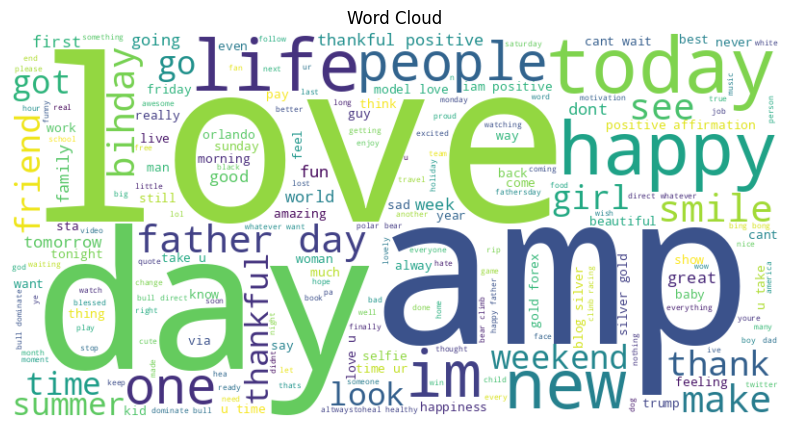

In [92]:
# Generate and display a word cloud to visualize the most frequent words in the cleaned tweets
all_clean_text = " ".join(df['clean_tweet'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_clean_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud")
plt.show()

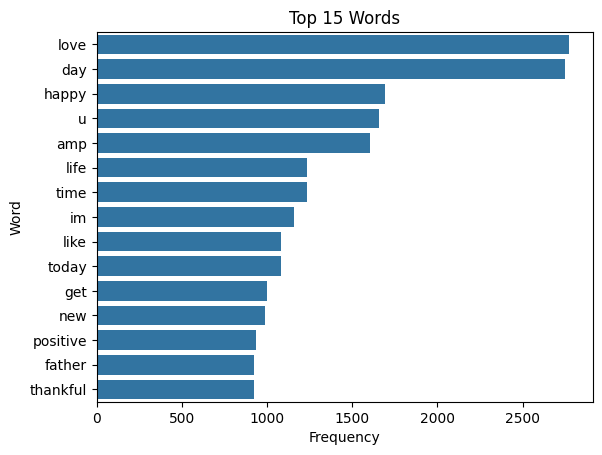

In [93]:
# Plot a bar chart showing the top 15 most frequent words in the cleaned tweets using Seaborn
word_freq = Counter(" ".join(df["clean_tweet"]).split())
common_words = pd.DataFrame(word_freq.most_common(15), columns=['Word', 'Frequency'])
sns.barplot(data=common_words, x='Frequency', y='Word')
plt.title("Top 15 Words")
plt.show()

In [94]:
# Extract features (cleaned tweets) and labels from the DataFrame for model training
# TOKENIZATION + PADDING
X = df['clean_tweet'].values
y = df['label'].values

In [95]:
# Split the data into training and validation sets (80% train, 20% validation) with a fixed random seed for reproducibility
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [96]:
# Tokenize the training text data, calculate vocabulary size and max sequence length,
# then convert tweets into padded sequences for uniform input to the neural network
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)
vocab_size = len(tokenizer.word_index) + 1
print("Vocab size: ",vocab_size)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)

max_len = int(np.percentile([len(x) for x in X_train_seq], 95))
print("\nMax Length: ",max_len)
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=max_len, padding='post')

Vocab size:  33695

Max Length:  13


In [97]:
# Define a function to visualize training and validation loss and accuracy over epochs for a given model
def plot_visualization(model_history, model_name):
  plt.figure(figsize=(12, 6))
  plt.subplot(1, 2, 1)
  plt.plot(model_history.history['loss'], label='Training Loss')
  plt.plot(model_history.history['val_loss'], label='Validation Loss')
  plt.title(f'{model_name}: Training vs Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(model_history.history['accuracy'], label='Training Accuracy')
  plt.plot(model_history.history['val_accuracy'], label='Validation Accuracy')
  plt.title(f'{model_name}: Training vs Validation Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()

In [98]:
# Define a function to evaluate a model on the validation set and print performance metrics including loss, accuracy, confusion matrix, and classification report
def evaluate_model(model, model_name):
  loss, accuracy = model.evaluate(X_val_pad, y_val, verbose=0)
  print('Test Loss:', loss)
  print('\nTest Accuracy:', accuracy)
  y_pred = (model.predict(X_val_pad) > 0.5).astype(int)
  print(f"\n\n{model_name} Accuracy: {accuracy_score(y_val, y_pred):.4f}")
  print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred))
  print("Classification Report:\n", classification_report(y_val, y_pred))

In [99]:
# Set up early stopping and model checkpointing to prevent overfitting and save the best model based on validation loss
early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, mode='min')

In [100]:
# Build and compile a Simple RNN model for binary text classification using an embedding layer and a sigmoid output
rnn_model1 = Sequential([
    Embedding(input_dim=vocab_size, output_dim=64, input_length=max_len),
    SimpleRNN(64),
    Dense(1, activation='sigmoid')
])
rnn_model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
rnn_model1.build(input_shape=(None, max_len))
rnn_model1.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)         │ (None, 13, 64)         │     2,156,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_2 (SimpleRNN)        │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,164,801 (8.26 MB)

 Trainable params: 2,164,801 (8.26 MB)

 Non-trainable params: 0 (0.00 B)

In [101]:
# Train the Simple RNN model using padded training data with early stopping and checkpointing enabled
rnn_model1_history = rnn_model1.fit(
    X_train_pad, y_train,
    epochs=10,
    batch_size=64,
    validation_data=(X_val_pad, y_val),
    callbacks=[early_stopping, checkpoint],
    verbose=1
)

Epoch 1/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9296 - loss: 0.2379

400/400 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - accuracy: 0.9297 - loss: 0.2377 - val_accuracy: 0.9573 - val_loss: 0.1303
Epoch 2/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9864 - loss: 0.0491 - val_accuracy: 0.9604 - val_loss: 0.1371
Epoch 3/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.9963 - loss: 0.0138 - val_accuracy: 0.9598 - val_loss: 0.1782
Epoch 4/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9981 - loss: 0.0074 - val_accuracy: 0.9568 - val_loss: 0.1909
Epoch 5/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9989 - loss: 0.0042 - val_accuracy: 0.9524 - val_loss: 0.2031


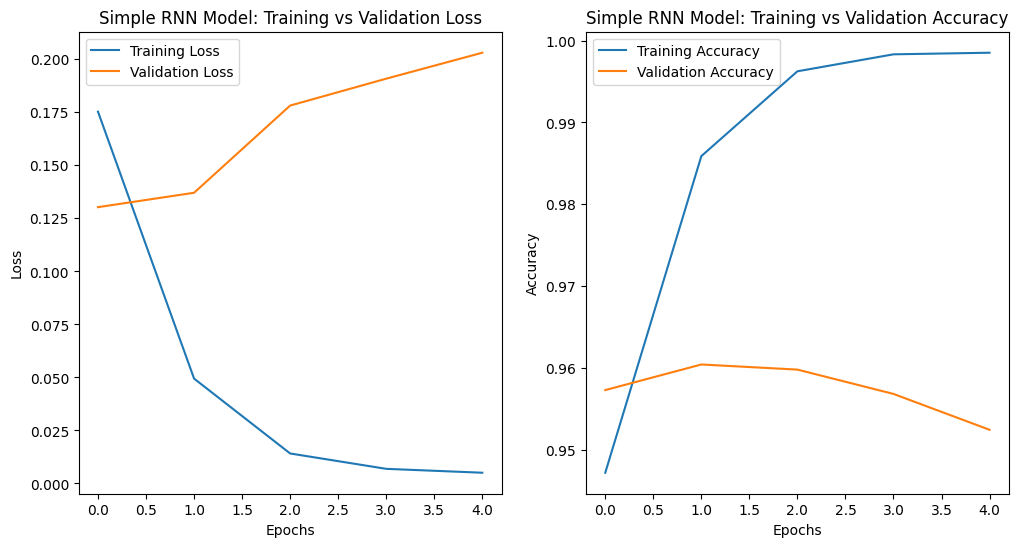

In [102]:
plot_visualization(rnn_model1_history, "Simple RNN Model")

In [103]:
# Evaluate the performance of the trained Simple RNN model on the validation set and display detailed metrics
evaluate_model(rnn_model1, "Simple RNN Model")

Test Loss: 0.13029012084007263

Test Accuracy: 0.9572970271110535
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


Simple RNN Model Accuracy: 0.9573
Confusion Matrix:
 [[5899   38]
 [ 235  221]]
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.99      0.98      5937
           1       0.85      0.48      0.62       456

    accuracy                           0.96      6393
   macro avg       0.91      0.74      0.80      6393
weighted avg       0.95      0.96      0.95      6393



In [104]:
rnn_model1.save('sachin_simple_rnn_model.h5')

### Model 2: LSTM with a trainable Embedding layer

In [105]:
# Define and compile an LSTM model for binary classification with a trainable embedding layer and sigmoid output
# LSTM with trainable embedding
rnn_model2 = Sequential([
    Embedding(input_dim=vocab_size, output_dim=64, input_length=max_len),
    LSTM(64),
    Dense(1, activation='sigmoid')
])

rnn_model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
rnn_model2.build(input_shape=(None, max_len))
rnn_model2.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)         │ (None, 13, 64)         │     2,156,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,189,569 (8.35 MB)

 Trainable params: 2,189,569 (8.35 MB)

 Non-trainable params: 0 (0.00 B)

In [106]:
# Train the LSTM model using the training data with validation, early stopping, and model checkpointing
rnn_model2_history = rnn_model2.fit(
    X_train_pad, y_train,
    epochs=10,
    batch_size=64,
    validation_data=(X_val_pad, y_val),
    callbacks=[early_stopping, checkpoint],
    verbose=1
)

Epoch 1/10
393/400 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9372 - loss: 0.2537

400/400 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.9374 - loss: 0.2523 - val_accuracy: 0.9592 - val_loss: 0.1188
Epoch 2/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9783 - loss: 0.0668 - val_accuracy: 0.9598 - val_loss: 0.1275
Epoch 3/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9931 - loss: 0.0256 - val_accuracy: 0.9618 - val_loss: 0.1296
Epoch 4/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9970 - loss: 0.0117 - val_accuracy: 0.9590 - val_loss: 0.1504
Epoch 5/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9976 - loss: 0.0110 - val_accuracy: 0.9571 - val_loss: 0.2066


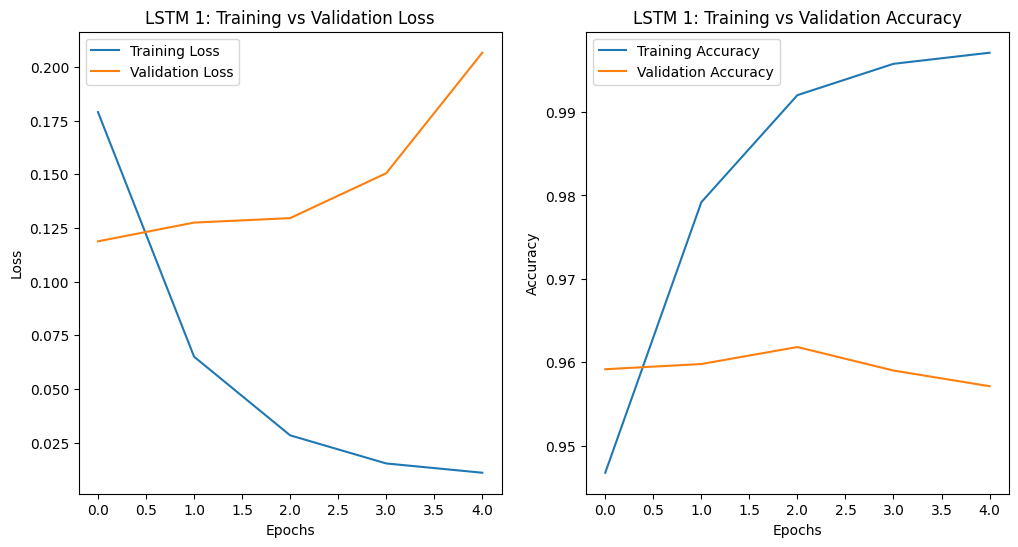

In [107]:
plot_visualization(rnn_model2_history, "LSTM 1")

In [108]:
evaluate_model(rnn_model2, "LSTM 1")

Test Loss: 0.11875635385513306

Test Accuracy: 0.9591740965843201
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


LSTM 1 Accuracy: 0.9592
Confusion Matrix:
 [[5905   32]
 [ 229  227]]
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.99      0.98      5937
           1       0.88      0.50      0.63       456

    accuracy                           0.96      6393
   macro avg       0.92      0.75      0.81      6393
weighted avg       0.96      0.96      0.95      6393



In [109]:
rnn_model2.save('sachin_lstm_1_model.h5')

### Model 3: LSTM with pretrained Word2Vec embeddings

In [110]:
import gensim.downloader as api

In [111]:
# Load pre-trained GloVe word embeddings and create an embedding matrix aligned with the tokenizer's vocabulary
embedding_model = api.load('glove-wiki-gigaword-50')
embedding_dim = 50
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    if word in embedding_model:
        embedding_matrix[i] = embedding_model[word]

In [112]:
# Build and compile an LSTM model that uses non-trainable pre-trained GloVe embeddings for binary text classification
rnn_model3 = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len,
              weights=[embedding_matrix], trainable=False),
    LSTM(64),
    Dense(1, activation='sigmoid')
])

rnn_model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
rnn_model3.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_8 (Embedding)         │ ?                      │     1,684,750 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,684,750 (6.43 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,684,750 (6.43 MB)

In [113]:
# Train the GloVe-based LSTM model using the training data with validation, early stopping, and checkpointing
rnn_model3_history = rnn_model3.fit(
    X_train_pad, y_train,
    epochs=10,
    batch_size=64,
    validation_data=(X_val_pad, y_val),
    callbacks=[early_stopping, checkpoint],
    verbose=1
)

Epoch 1/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9184 - loss: 0.2485 - val_accuracy: 0.9384 - val_loss: 0.1723
Epoch 2/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9463 - loss: 0.1530 - val_accuracy: 0.9481 - val_loss: 0.1509
Epoch 3/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9484 - loss: 0.1392 - val_accuracy: 0.9482 - val_loss: 0.1529
Epoch 4/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9537 - loss: 0.1257 - val_accuracy: 0.9487 - val_loss: 0.1418
Epoch 5/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9592 - loss: 0.1102 - val_accuracy: 0.9503 - val_loss: 0.1556
Epoch 6/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9644 - loss: 0.1036 - val_accuracy: 0.9515 - val_loss: 0.1425
Epoch 7/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9672 - loss: 0.0962 - val_accuracy: 0.9514 - val_loss: 0.1437
Epoch 8/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9691 - loss: 0.0860 - val_accuracy: 0.

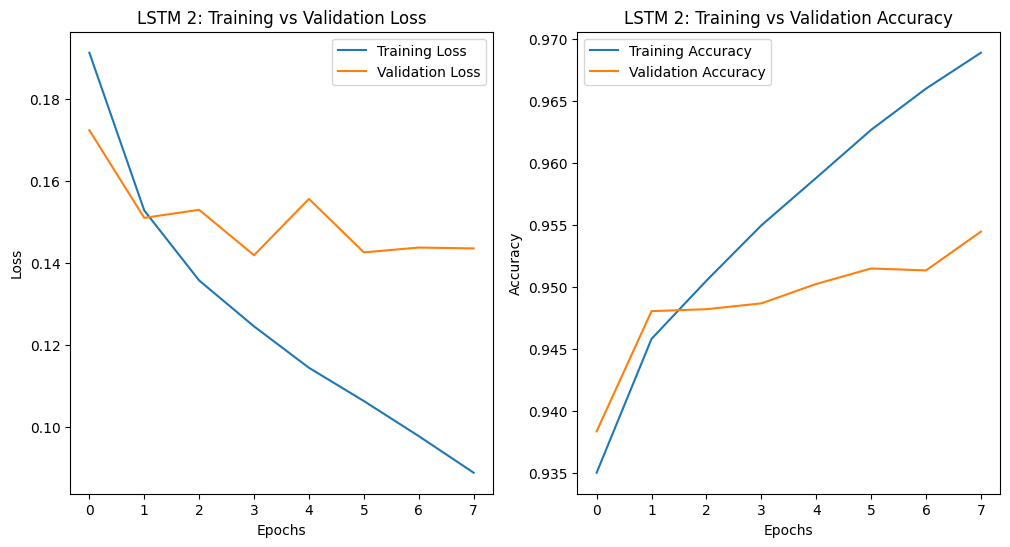

In [114]:
plot_visualization(rnn_model3_history, "LSTM 2")

In [115]:
evaluate_model(rnn_model3, "LSTM 2")

Test Loss: 0.14184486865997314

Test Accuracy: 0.9486938714981079
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


LSTM 2 Accuracy: 0.9487
Confusion Matrix:
 [[5862   75]
 [ 253  203]]
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.99      0.97      5937
           1       0.73      0.45      0.55       456

    accuracy                           0.95      6393
   macro avg       0.84      0.72      0.76      6393
weighted avg       0.94      0.95      0.94      6393



In [116]:
rnn_model3.save('sachin_lstm_2_model.h5')

### Predictions

In [117]:
# Define a text cleaning function to preprocess input text by removing URLs, mentions, hashtags, digits, punctuation, and stopwords, then apply lemmatization
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|@\w+|#\w+|\d+", '', text)
    text = re.sub(rf"[{re.escape(string.punctuation)}]", '', text)
    text = re.sub(r"\b(?:{})\b".format('|'.join(stop_words)), '', text)
    text = " ".join([lemmatizer.lemmatize(w) for w in text.split()])
    return text.strip()


In [118]:
# 🧪 PREDICT ON CUSTOM TEXT
def predict_text(model, model_name, text):
    cleaned = clean_text(text)
    seq = tokenizer.texts_to_sequences([cleaned])
    pad = pad_sequences(seq, maxlen=max_len, padding='post')
    pred = model.predict(pad)[0][0]
    sentiment = 'Racist/Sexist' if pred > 0.5 else 'Not Racist/Sexist'
    print(f"\nPrediction made by model: {model_name}\n")
    print(f"Text: {text}\nPrediction: {sentiment} ({pred:.3f})")

In [119]:
# Model 1 Prediction
predict_text(rnn_model1, "Simple RNN Model", "happy father day to all the fathers out there! #fathersday   #sunday #family")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step

Prediction made by model: Simple RNN Model

Text: happy father day to all the fathers out there! #fathersday   #sunday #family
Prediction: Not Racist/Sexist (0.014)


In [120]:
# Model 2 Prediction
predict_text(rnn_model2, "LSTM 1", '"simply assault" is equal to spitting on someone. authoritys got the charges all wrong. these guy will walk   ')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step

Prediction made by model: LSTM 1

Text: "simply assault" is equal to spitting on someone. authoritys got the charges all wrong. these guy will walk   
Prediction: Not Racist/Sexist (0.284)


In [121]:
# Model 3 Prediction
predict_text(rnn_model3, "LSTM 2", "smile with no filter #instamood #picoftheday   #behealthy #summer #bliss #bitchplease")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step

Prediction made by model: LSTM 2

Text: smile with no filter #instamood #picoftheday   #behealthy #summer #bliss #bitchplease
Prediction: Not Racist/Sexist (0.001)


In [122]:
# Install Gradio and launch an interactive interface for predicting hate speech in tweets using selectable RNN/LSTM models
!pip install gradio

import gradio as gr
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Define the models
models = {
    "Simple RNN": rnn_model1,
    "LSTM": rnn_model2,
    "W2VLSTM": rnn_model3
}

def predict_hate_speech(text, model_choice):
    cleaned = clean_text(text)
    seq = tokenizer.texts_to_sequences([cleaned])
    pad = pad_sequences(seq, maxlen=max_len, padding='post')
    model = models[model_choice]
    pred = model.predict(pad)[0][0]
    sentiment = "🟥 Racist/Sexist" if pred > 0.5 else "🟩 Not Racist/Sexist"
    confidence = pred if pred > 0.5 else 1 - pred
    return f"{sentiment}\nConfidence: {confidence:.2%}"

gr.Interface(
    fn=predict_hate_speech,
    inputs=[
        gr.Textbox(placeholder="Enter a tweet...", lines=2),
        gr.Dropdown(choices=["Simple RNN", "LSTM", "W2VLSTM"], label="Select Model")
    ],
    outputs="text",
    title="Tweet Classifier",
    description="Enter a tweet and select a model to detect if it's racist/sexist or not."
).launch()


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://1d3022c978fbcffb8c.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
